Exercise 1
## 1. Setting things up.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import pylab
import os

# to print plots inline
%matplotlib inline

In [2]:
# Specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
sigma_z = 0.213
mu = 0.000
rho = 0.7605
sizez = 9
params = alpha_k, alpha_l, delta, psi, w, r

With an AR(1) productivity shock, the relationship between discount and interest rates still holds at steady-state.

In [3]:
betafirm = (1 / (1 + r))

We would then want to set up the grids for capital and productivity.
The capital level of firms without any adjustment cost could still be a good starting point. Specifically,  
$$ k_{t+1} = \left[\left(\frac{\alpha_{k}}{\bar{r}  + \delta}\right)^{1-\alpha_{l}}\left(\frac{\alpha_{l}}{w}\right)^{\alpha_{l}}z_{t+1}^{\alpha_{l}}\right]^{1-\alpha_{k}-\alpha_{l}} $$
If we replace $z_t$ by its expected value $E[z_t] = 1$, the equation could be reduced similarly to  
$$ k_{t+1} = \left[\left(\frac{\alpha_{k}}{\bar{r}  + \delta}\right)^{1-\alpha_{l}}\left(\frac{\alpha_{l}}{w}\right)^{\alpha_{l}}\right]^{1-\alpha_{k}-\alpha_{l}}$$
and we could set up the capital grid same as in the deterministic case

In [4]:
# Set up K-grid
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2 * kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

I choose to use the Rouwenhorst method for approximating an AR(1) process since it outperforms the other methods when $\rho$ is close to 1

In [5]:
import ar1_approx as ar1
num_sigma = 4
step = (num_sigma * sigma_z) / (sizez / 2)
pi, zvec = ar1.rouwen(rho, mu, step, sizez)
zvec = np.exp(zvec)

We would then want to set up the grid for per-period cash flow, which differs from the deterministic case only in the sense that firm revenue now depends upon $z_t$ as well: 
$$ e(k,k') = \pi(z, k) - (k'-(1-\delta)k) - \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

In [6]:
# operating profits, op
def op(z, k, params):
    alpha_k, alpha_l, delta, psi, w, r = params
    op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * ((k ** alpha_k) ** (1 / (1 - alpha_l)))) * z ** (1/(1 - alpha_l))
    return op

# firm cash flow, e
e = np.zeros((sizek, sizek, sizez))
for i in range(sizek):
    for j in range(sizek):
        for k in range(sizez):
            e[i, j, k] = (op(zvec[k], kvec[i], params) - kvec[j] + ((1 - delta) * kvec[i]) - 
                          ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)/ kvec[i]))

## 2. Value Function Iteration.
The Bellman equation now becomes:  
$$ V(z,k) = max_{k'} \pi(z,k) - p^{k}(k'-(1-\delta)k) - c(k',k) + \beta E[V(z',k')|z] $$
, which in terms of the discretized grids, could be written as 
$$ V(z_i,k) = max_{k'\in \text{k grid}} \pi(z,k) - p^{k}(k'-(1-\delta)k) - c(k',k) + \beta \sum_{i=1}^9 V(z_j,k') p_{ij} $$, where $p_{ij}$ represents the $i, j$th entry of transition matrix $P$. We are trying to find a fixed point of the mapping.

In [7]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek, sizez))  # initial guess of value function
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
VFiter = 1

start = time.time()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez): # loop over z
                Vmat[i, j, k] = e[i, j, k] + betafirm * np.dot(V[j, :], pi[:, k])
    
    # iteration for graphing later
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1
end = time.time()

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
    print('Time taken for convergence:' + str(end - start))
else:
    print('Value function did not converge')

Value function converged after this many iterations: 357
Time taken for convergence:30.284682989120483


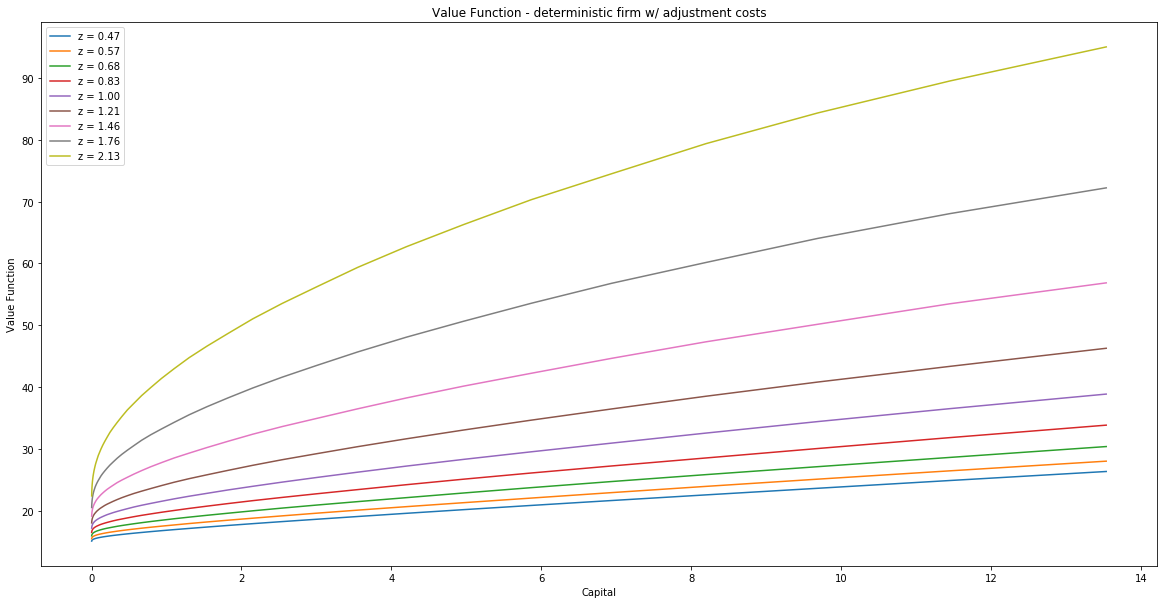

In [20]:
# Value Function Plots
pylab.rcParams['figure.figsize'] = (20, 10)
ax = plt.subplot(111)
for i in range(9):
    ax.plot(kvec, V[:,i], label= str('z = ' + "%.2f" %zvec[i]))
ax.set_xlabel('Capital')
ax.set_ylabel('Value Function')
ax.set_title('Value Function - deterministic firm w/ adjustment costs')
ax.legend()
plt.show()


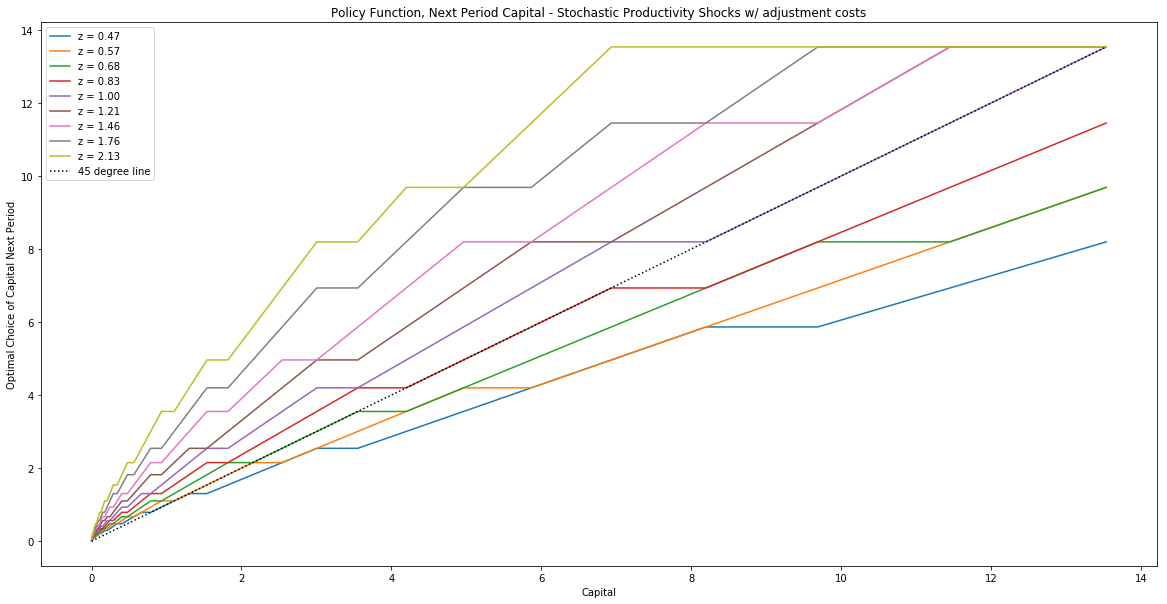

In [18]:
optK = kvec[PF]
pylab.rcParams['figure.figsize'] = (20, 10)

ax1 = plt.subplot(111)
for i in range(9):
    plt.plot(kvec, optK[:, i], label=str('z = ' + "%.2f" %zvec[i]))
ax1.plot(kvec, kvec, 'k:', label='45 degree line')
ax1.set_xlabel('Capital')
ax1.set_ylabel('Optimal Choice of Capital Next Period')
ax1.legend()
ax1.set_title('Policy Function, Next Period Capital - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')


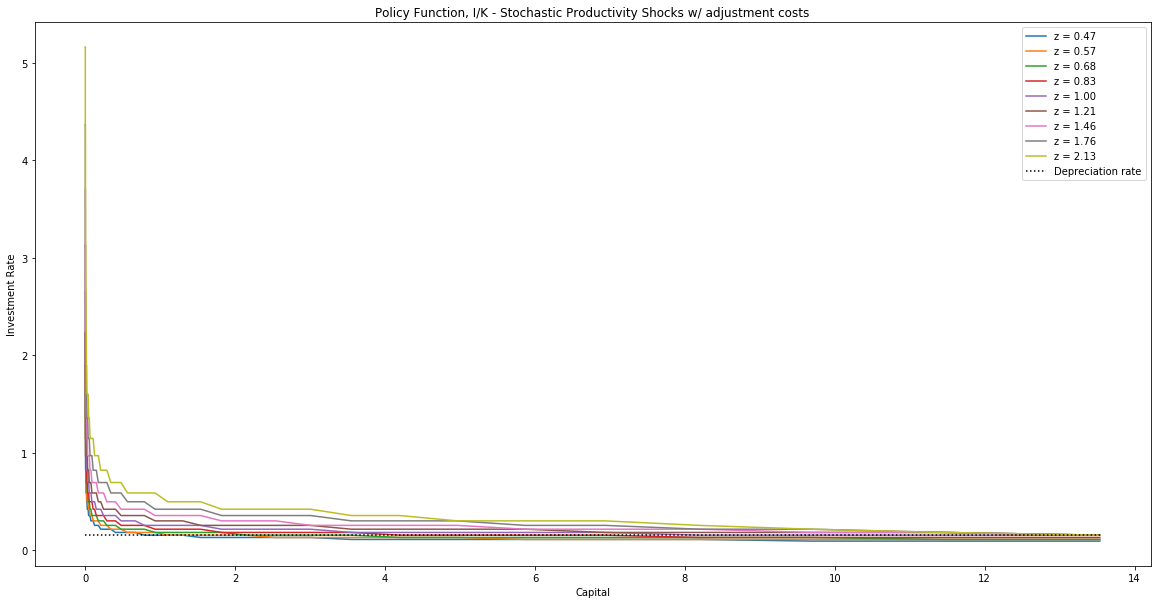

In [19]:
optI = optK - (1 - delta) * optK
pylab.rcParams['figure.figsize'] = (20, 10)
ax2 = plt.subplot(111)
for i in range(9):
    plt.plot(kvec, optI[:,i]/kvec, label=str('z = ' + "%.2f" %zvec[i]))
ax2.plot(kvec,(np.ones(kvec.shape[0])*delta), 'k:', label='Depreciation rate')
ax2.set_xlabel('Capital')
ax2.set_ylabel('Investment Rate')
ax2.set_title('Policy Function, I/K - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
ax2.legend()
plt.show()

As we see from the plots, as productivity increases, capital choice for next period as well as investment rate both increase. 